# Customer Segmentation Supervised Learning Approach

we need to reduce dimensions and visualize it

## Getting Data, getting to know data and importing libraries

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vetrirah/customer")

print("Path to dataset files:", path)

100%|██████████| 105k/105k [00:00<00:00, 526kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/vetrirah/customer/versions/1


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)
df_train = pd.read_csv(path + '/Train.csv')
df_test = pd.read_csv(path + '/Test.csv')
df_sample = pd.read_csv(path + '/sample_submission.csv')

df_test = df_test.merge(df_sample, on='ID', how='left')
df = pd.concat([df_train, df_test], ignore_index=True)
df_train.shape, df_test.shape, df.shape

((8068, 11), (2627, 11), (10695, 11))

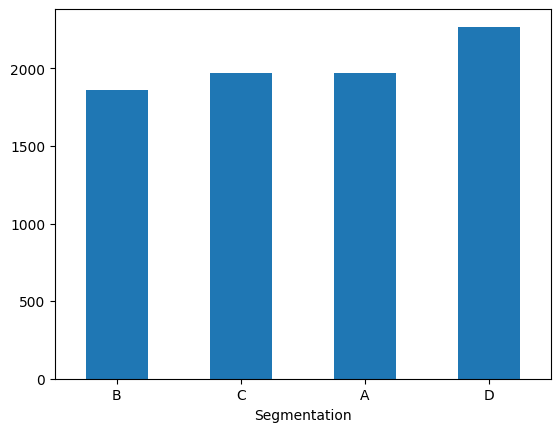

In [ ]:
df_train['Segmentation'].value_counts().sort_values().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

## Pipelines

In [ ]:
from sklearn.model_selection import train_test_split

cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']
num_cols = ['Age', 'Work_Experience', 'Family_Size']
drop_cols = ['ID']
target_col = 'Segmentation'

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cat_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ]
)

preprocessor = ColumnTransformer(
    [
        ('num_pipe', num_pipe, num_cols),
        ('cat_pipe', cat_pipe, cat_cols)
    ]
)


X_train_transformed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())
X_transformed = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())


from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_transformed, y_train)
rf_clf.score(X_test_transformed, y_test)

0.394109396914446

In [ ]:
# using KNNImputer

num_pipe_knn = Pipeline(
    [
        ('imputer_knn', KNNImputer(n_neighbors=3)),
        ('scaler_knn', StandardScaler())
    ]
)

cat_pipe_knn = Pipeline(
    [
        ('imputer_knn', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder())
    ]
)

preprocessor_knn = ColumnTransformer(
    [
        ('num_pipe_knn', num_pipe_knn, num_cols),
        ('cat_pipe_knn', cat_pipe_knn,cat_cols)
    ]
)

X_train_transformed_knn = pd.DataFrame(preprocessor_knn.fit_transform(X_train), columns=preprocessor_knn.get_feature_names_out())
X_test_transformed_knn = pd.DataFrame(preprocessor_knn.transform(X_test), columns=preprocessor_knn.get_feature_names_out())

rf_clf_knn = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_knn.fit(X_train_transformed_knn, y_train)
rf_clf_knn.score(X_test_transformed_knn, y_test)

0.394109396914446

not so different

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X_transformed)

cumsum = np.cumsum(pca.explained_variance_ratio_)

print(f'old shape: {X_transformed.shape}')
print(f'new shape: {X2D.shape}')
print(f'n_components: {pca.n_components}')
print(f'explained variance ratio: {pca.explained_variance_ratio_}')
print(f'explained variance cumulative ratio: {cumsum}')
print(f'unexplained variance ratio: {1-pca.explained_variance_ratio_.sum()}')


old shape: (10695, 28)
new shape: (10695, 2)
n_components: 2
explained variance ratio: [0.25445738 0.17490423]
explained variance cumulative ratio: [0.25445738 0.42936161]
unexplained variance ratio: 0.5706383949883789


In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_transformed)

cumsum = np.cumsum(pca.explained_variance_ratio_.round(3))
d = np.argmax(cumsum >= 0.95) + 1

print(f'explained variance ratio: {pca.explained_variance_ratio_.round(3)}')
print(f'explained cumulative variance ratio: {cumsum.round(3)}')
print('default n_components for PCA is all the columns.')
print(f'components (columns) for 95% explained variance: {d}')

explained variance ratio: [0.254 0.175 0.13  0.079 0.074 0.058 0.041 0.032 0.026 0.02  0.018 0.018
 0.015 0.013 0.01  0.009 0.007 0.006 0.005 0.005 0.003 0.002 0.    0.
 0.    0.    0.    0.   ]
explained cumulative variance ratio: [0.254 0.429 0.559 0.638 0.712 0.77  0.811 0.843 0.869 0.889 0.907 0.925
 0.94  0.953 0.963 0.972 0.979 0.985 0.99  0.995 0.998 1.    1.    1.
 1.    1.    1.    1.   ]
default n_components for PCA is all the columns.
components (columns) for 95% explained variance: 14


In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_transformed)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(f'shape before pca 0.95: {X_transformed.shape}')
print(f'shape after pca 0.95: {X_reduced.shape}')
print(f'explained variance ratio by each component for 95%: {pca.explained_variance_ratio_}')
print(f'explained cumulative variance ratio by each component for 95%: {cumsum}')
print(f'unexplained variance ratio: {1 - pca.explained_variance_ratio_.sum()}')

shape before pca 0.95: (10695, 28)
shape after pca 0.95: (10695, 14)
explained variance ratio by each component for 95%: [0.25445738 0.17490423 0.13049253 0.07925302 0.0742951  0.05800905
 0.04080932 0.0319831  0.02554402 0.0197589  0.01847043 0.01764371
 0.01539496 0.01295255]
explained cumulative variance ratio by each component for 95%: [0.25445738 0.42936161 0.55985413 0.63910715 0.71340225 0.7714113
 0.81222062 0.84420373 0.86974775 0.88950664 0.90797708 0.92562079
 0.94101575 0.9539683 ]
unexplained variance ratio: 0.046031701268310465


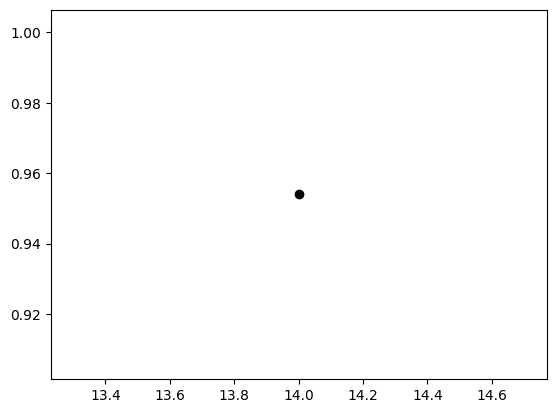

In [ ]:
plt.plot(d, cumsum[d-1], 'ko')

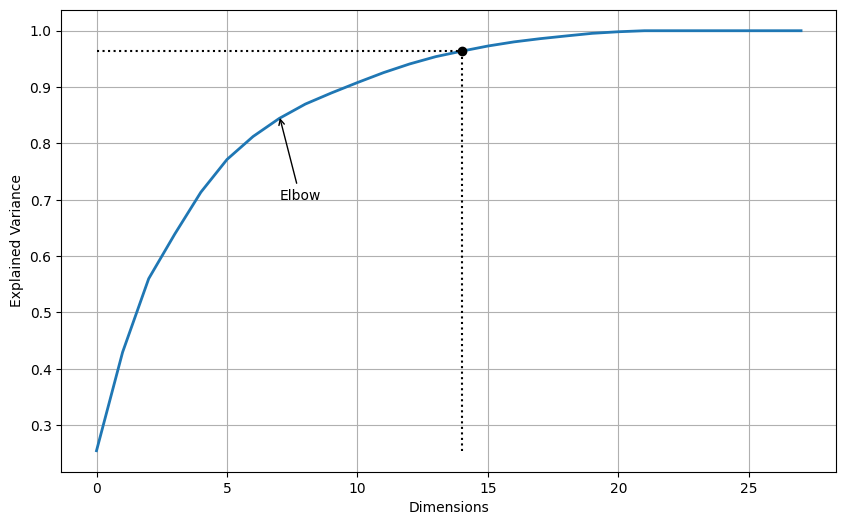

In [ ]:
pca = PCA()
X_reduced = pca.fit_transform(X_transformed)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=2)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.plot([d,d], [pca.explained_variance_ratio_[0], cumsum[d]], 'k:')
plt.plot([0,d], [cumsum[d], cumsum[d]], 'k:')
plt.plot(d, cumsum[d], 'ko')
plt.annotate(
    'Elbow',
    xy=(7, 0.85),
    xytext=(7, 0.7),
    arrowprops=(dict(arrowstyle='->')
    )
)
plt.grid(True)
plt.show()

Beyond dimension 5 increase in explained variance is small, beyond 15 it is negligible. Therefore optimal number of components is somewhere between 5 and 15

In [ ]:
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
pca_pipe = Pipeline(
    [
        ('pca', PCA(n_components=8, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
)

pca_pipe.fit(X_train_transformed, y_train)
pca_pipe.score(X_test_transformed, y_test)

0.4067321178120617

## AdaBoost

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
pca_pipe_adaboost = Pipeline(
    [
        ('pca_adaboost', PCA(n_components=8, random_state=42)),
        ('adaboost', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5))
    ]
)

pca_pipe_adaboost.fit(X_train_transformed, y_train)
pca_pipe_adaboost.score(X_test_transformed, y_test)

0.48714352501168773

In [ ]:
pca_pipe_adaboost.get_params()

{'memory': None,
 'steps': [('pca_adaboost', PCA(n_components=8, random_state=42)),
  ('adaboost',
   AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                      learning_rate=0.5, n_estimators=200))],
 'transform_input': None,
 'verbose': False,
 'pca_adaboost': PCA(n_components=8, random_state=42),
 'adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                    learning_rate=0.5, n_estimators=200),
 'pca_adaboost__copy': True,
 'pca_adaboost__iterated_power': 'auto',
 'pca_adaboost__n_components': 8,
 'pca_adaboost__n_oversamples': 10,
 'pca_adaboost__power_iteration_normalizer': 'auto',
 'pca_adaboost__random_state': 42,
 'pca_adaboost__svd_solver': 'auto',
 'pca_adaboost__tol': 0.0,
 'pca_adaboost__whiten': False,
 'adaboost__algorithm': 'deprecated',
 'adaboost__estimator__ccp_alpha': 0.0,
 'adaboost__estimator__class_weight': None,
 'adaboost__estimator__criterion': 'gini',
 'adaboost__estimator__max_depth': 1,
 'adab

In [ ]:
np.hstack((np.arange(0.2, 1.2, 0.2), np.arange(3, 11, 2)))

array([0.2, 0.4, 0.6, 0.8, 1. , 3. , 5. , 7. , 9. ])

In [ ]:
param_grid_adaboost = {'pca_adaboost__n_components': np.arange(10, 15),
                       'adaboost__n_estimators': np.arange(100, 250, 50),
                       'adaboost__learning_rate': [0.5, 1.0],
                       'adaboost__estimator__criterion': ['gini', 'entropy'],
                       'adaboost__estimator__min_samples_split': [6, 10],
                       'adaboost__estimator__max_features': ['sqrt']}

grid_search_adaboost = GridSearchCV(estimator=pca_pipe_adaboost, cv=3, scoring='accuracy', param_grid=param_grid_adaboost, n_jobs=-1)
grid_search_adaboost.fit(X_train_transformed, y_train)
grid_search_adaboost.score(X_test_transformed, y_test)

0.4857410004675082

In [ ]:
grid_search_adaboost.best_estimator_

Pipeline(steps=[('pca_adaboost', PCA(n_components=14, random_state=42)),
                ('adaboost',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                     max_features='sqrt',
                                                                     min_samples_split=6),
                                    learning_rate=0.5, n_estimators=100))])

In [ ]:
grid_search_adaboost.best_params_

{'adaboost__estimator__criterion': 'gini',
 'adaboost__estimator__max_features': 'sqrt',
 'adaboost__estimator__min_samples_split': 6,
 'adaboost__learning_rate': 0.5,
 'adaboost__n_estimators': 100,
 'pca_adaboost__n_components': 14}

In [ ]:
pd.DataFrame(grid_search_adaboost.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_adaboost__estimator__criterion,param_adaboost__estimator__max_features,param_adaboost__estimator__min_samples_split,param_adaboost__learning_rate,param_adaboost__n_estimators,param_pca_adaboost__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,1.924233,0.042908,0.158010,0.031119,gini,sqrt,6,0.5,100,14,"{'adaboost__estimator__criterion': 'gini', 'ad...",0.484222,0.511220,0.491585,0.495676,0.011395,1
63,2.068345,0.012276,0.131274,0.001196,entropy,sqrt,6,0.5,100,13,"{'adaboost__estimator__criterion': 'entropy', ...",0.479313,0.508766,0.494039,0.494039,0.012024,2
41,4.580579,0.818482,0.256785,0.008941,gini,sqrt,10,0.5,200,11,"{'adaboost__estimator__criterion': 'gini', 'ad...",0.478612,0.496143,0.504909,0.493221,0.010933,3
112,3.760761,1.022806,0.250198,0.048342,entropy,sqrt,10,1.0,150,12,"{'adaboost__estimator__criterion': 'entropy', ...",0.476508,0.498597,0.502805,0.492637,0.011534,4
64,2.429571,0.497152,0.150422,0.011996,entropy,sqrt,6,0.5,100,14,"{'adaboost__estimator__criterion': 'entropy', ...",0.478962,0.504208,0.494741,0.492637,0.010413,4
39,2.717716,0.035304,0.195958,0.005074,gini,sqrt,10,0.5,150,14,"{'adaboost__estimator__criterion': 'gini', 'ad...",0.478962,0.501753,0.496143,0.492286,0.009696,6
57,3.541442,0.019346,0.256316,0.006120,gini,sqrt,10,1.0,200,12,"{'adaboost__estimator__criterion': 'gini', 'ad...",0.473703,0.501052,0.502104,0.492286,0.013147,6
2,1.784703,0.029710,0.145243,0.011326,gini,sqrt,6,0.5,100,12,"{'adaboost__estimator__criterion': 'gini', 'ad...",0.482118,0.500701,0.494039,0.492286,0.007687,8
26,4.408869,0.956290,0.250784,0.002586,gini,sqrt,6,1.0,200,11,"{'adaboost__estimator__criterion': 'gini', 'ad...",0.478962,0.498247,0.498247,0.491819,0.009091,9
102,4.373989,0.362724,0.249906,0.002496,entropy,sqrt,10,0.5,200,12,"{'adaboost__estimator__criterion': 'entropy', ...",0.483520,0.497546,0.494390,0.491819,0.006008,10


In [ ]:
param_grid_adaboost = {'pca_adaboost__n_components': [14],
                       'adaboost__n_estimators': [100, 150, 200],
                       'adaboost__learning_rate': [0.3, 0.5, 0.7],
                       'adaboost__estimator__criterion': ['gini'],
                       'adaboost__estimator__min_samples_split': [4, 6, 8],
                       'adaboost__estimator__max_features': ['sqrt']}

grid_search_adaboost = GridSearchCV(estimator=pca_pipe_adaboost, cv=3, scoring='accuracy', param_grid=param_grid_adaboost, n_jobs=-1)
grid_search_adaboost.fit(X_train_transformed, y_train)
grid_search_adaboost.score(X_test_transformed, y_test)

0.48807854137447404

In [ ]:
grid_search_adaboost.best_params_

{'adaboost__estimator__criterion': 'gini',
 'adaboost__estimator__max_features': 'sqrt',
 'adaboost__estimator__min_samples_split': 4,
 'adaboost__learning_rate': 0.7,
 'adaboost__n_estimators': 200,
 'pca_adaboost__n_components': 14}

## Fine-tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'pca__n_components': np.arange(1, 15)}
grid_search = GridSearchCV(pca_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,3.472047,0.457439,0.086103,0.027369,5,{'pca__n_components': 5},0.429322,0.428404,0.451783,0.446523,0.438340,0.438874,0.009233,1
6,4.204803,0.777743,0.080696,0.027561,7,{'pca__n_components': 7},0.415888,0.427236,0.457043,0.431911,0.436587,0.433733,0.013531,2
8,5.003075,0.809788,0.064504,0.000993,9,{'pca__n_components': 9},0.424065,0.421975,0.450029,0.428989,0.443600,0.433732,0.011110,3
9,5.187346,0.863088,0.077262,0.026832,10,{'pca__n_components': 10},0.422897,0.428404,0.440678,0.424898,0.443016,0.431979,0.008281,4
5,3.963218,0.971576,0.071528,0.009281,6,{'pca__n_components': 6},0.426986,0.423144,0.444185,0.444769,0.420807,0.431978,0.010396,5
7,3.501152,0.237173,0.078638,0.025630,8,{'pca__n_components': 8},0.422313,0.424313,0.441847,0.434249,0.433665,0.431277,0.007143,6
10,6.230054,1.245891,0.104063,0.027498,11,{'pca__n_components': 11},0.424650,0.426067,0.439509,0.424313,0.440094,0.430926,0.007273,7
11,5.398785,0.905338,0.073635,0.014611,12,{'pca__n_components': 12},0.419977,0.427236,0.439509,0.412040,0.430158,0.425784,0.009298,8
12,5.313807,1.062832,0.078145,0.023716,13,{'pca__n_components': 13},0.413551,0.424898,0.434833,0.411455,0.443016,0.425551,0.012118,9
13,5.648952,0.719602,0.115004,0.039944,14,{'pca__n_components': 14},0.418224,0.417884,0.433665,0.413209,0.434833,0.423563,0.008911,10


In [ ]:
cv_res.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_pca__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [ ]:
cv_res[['param_pca__n_components', 'mean_test_score']]

,param_pca__n_components,mean_test_score
4,5,0.438874
6,7,0.433733
8,9,0.433732
9,10,0.431979
5,6,0.431978
7,8,0.431277
10,11,0.430926
11,12,0.425784
12,13,0.425551
13,14,0.423563


In [ ]:
grid_search.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('pca', PCA(n_components=8, random_state=42)),
  ('rf', RandomForestClassifier(random_state=42))],
 'estimator__transform_input': None,
 'estimator__verbose': False,
 'estimator__pca': PCA(n_components=8, random_state=42),
 'estimator__rf': RandomForestClassifier(random_state=42),
 'estimator__pca__copy': True,
 'estimator__pca__iterated_power': 'auto',
 'estimator__pca__n_components': 8,
 'estimator__pca__n_oversamples': 10,
 'estimator__pca__power_iteration_normalizer': 'auto',
 'estimator__pca__random_state': 42,
 'estimator__pca__svd_solver': 'auto',
 'estimator__pca__tol': 0.0,
 'estimator__pca__whiten': False,
 'estimator__rf__bootstrap': True,
 'estimator__rf__ccp_alpha': 0.0,
 'estimator__rf__class_weight': None,
 'estimator__rf__criterion': 'gini',
 'estimator__rf__max_depth': None,
 'estimator__rf__max_features': 'sqrt',
 'estimator__rf__max_leaf_nodes': None,
 'estimator__rf__max_samples': None,

In [ ]:
pca_pipe.get_params()

{'memory': None,
 'steps': [('pca', PCA(n_components=8, random_state=42)),
  ('rf', RandomForestClassifier(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'pca': PCA(n_components=8, random_state=42),
 'rf': RandomForestClassifier(random_state=42),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 8,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': 42,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__monotonic_cst': None,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__war

## Visualization 2D and 3D

built a model, fine tuned the model with gridsearchcv, now let's try to visualize it

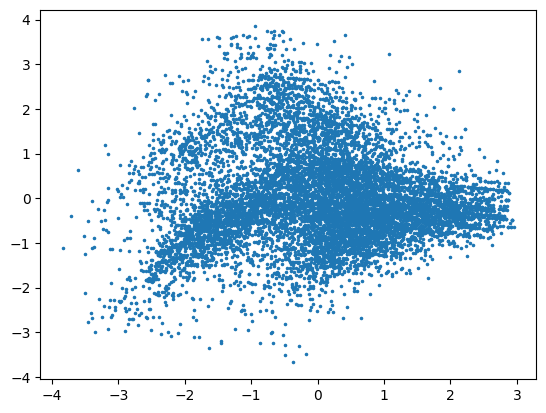

In [ ]:
plt.scatter(X2D[:, 0], X2D[:, 1], s=2.4);
# plt.axis([-6,4,-6,5])

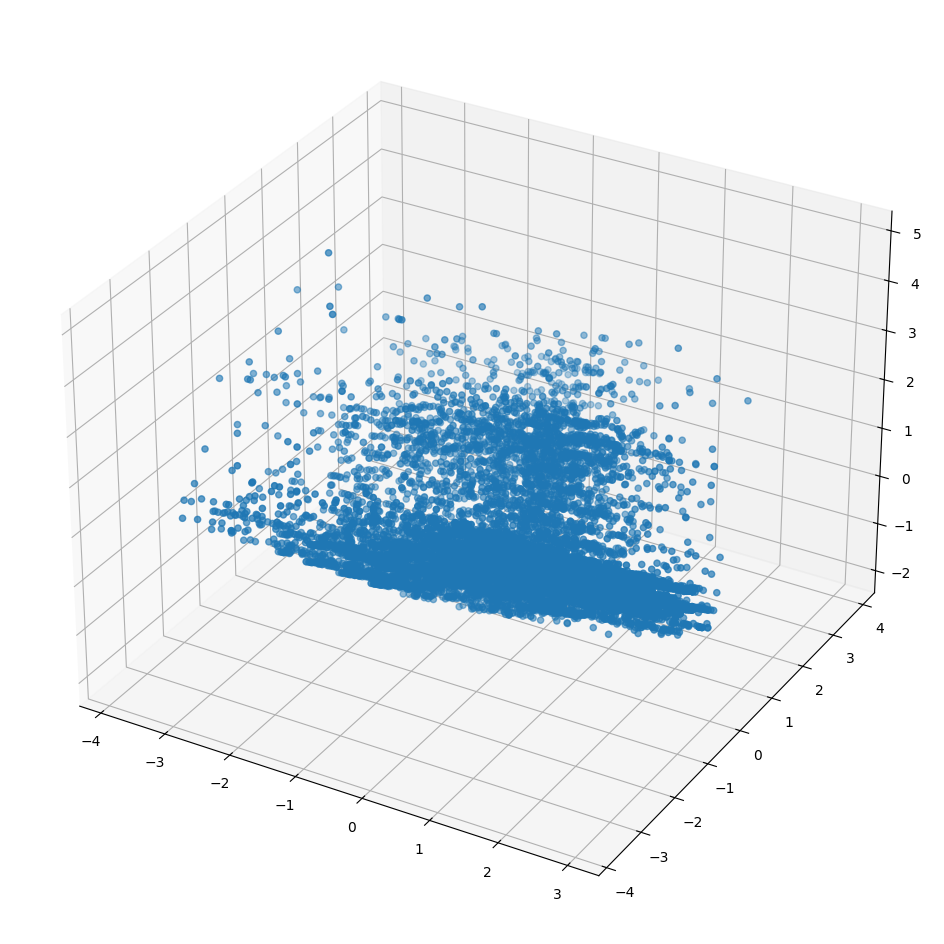

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

pca_3 = PCA(n_components=3)
X3D = pca.fit_transform(X_transformed)

ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2]);

from visualization, did not understand a thing. but that'll change